In [ ]:
# Install required libraries
!pip install librosa==0.10.1 plotly==5.18.0 pandas==2.0.3 numpy==1.24.3 scikit-learn==1.2.2 xgboost==2.0.2 matplotlib==3.7.3 seaborn==0.13.0 scipy==1.10.1 tqdm

# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy.stats import pearsonr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import pickle

# Ignore warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

1. **Data Loading and Exploration**

In [ ]:
# Load the training and testing data
!pip install panda
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/shl-intern-hiring-assessment/dataset/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/shl-intern-hiring-assessment/dataset/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/shl-intern-hiring-assessment/dataset/sample_submission.csv')

# Display information about the datasets
print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)
print("Sample submission shape:", sample_submission.shape)

# Display the first few rows of each dataset
train_df.head()

  Preparing metadata (setup.py) ... done
  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7239 sha256=e566f38a75caa24fd0a203d5b1f4e58c9731ac2297736d9356399fbdd4deeaf6
  Stored in directory: /root/.cache/pip/wheels/df/5c/39/36f8dae25a1e88d6ec4411dec4a143781e64fdff6897758eec
Successfully built panda
Training data shape: (444, 2)
Testing data shape: (195, 1)
Sample submission shape: (195, 2)


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


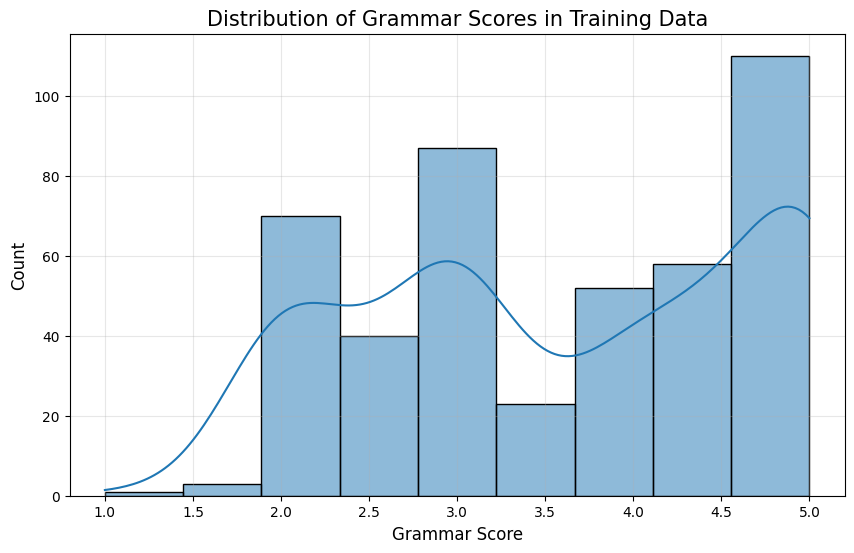

Target variable statistics:
count    444.000000
mean       3.617117
std        1.114151
min        1.000000
25%        2.500000
50%        3.500000
75%        4.500000
max        5.000000
Name: label, dtype: float64


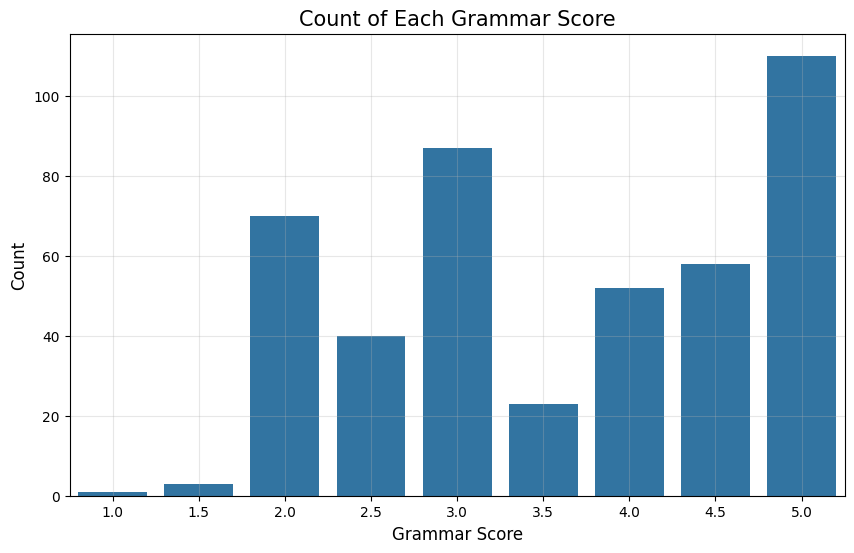

In [ ]:
# Explore the target variable distribution
!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='label', bins=9, kde=True)
plt.title('Distribution of Grammar Scores in Training Data', fontsize=15)
plt.xlabel('Grammar Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Statistics of the target variable
print("Target variable statistics:")
print(train_df['label'].describe())

# Count of each score in the training data
score_counts = train_df['label'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=score_counts.index, y=score_counts.values)
plt.title('Count of Each Grammar Score', fontsize=15)
plt.xlabel('Grammar Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

2. **Audio Feature Extraction Functions**

In [ ]:
def load_audio_file(file_path):
    """
    Load an audio file using librosa.

    Parameters:
    file_path (str): Path to the audio file

    Returns:
    tuple: audio time series (y) and sampling rate (sr)
    """
    try:
        y, sr = librosa.load(file_path, sr=None)
        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

def extract_features(y, sr):
    """
    Extract audio features from an audio time series.

    Parameters:
    y (np.ndarray): Audio time series
    sr (int): Sampling rate

    Returns:
    dict: Dictionary of extracted features
    """
    if y is None or sr is None:
        return None

    features = {}

    # Basic features
    features['duration'] = librosa.get_duration(y=y, sr=sr)
    features['zero_crossing_rate_mean'] = np.mean(librosa.feature.zero_crossing_rate(y=y)[0])
    features['zero_crossing_rate_std'] = np.std(librosa.feature.zero_crossing_rate(y=y)[0])

    # RMS energy Measures the energy of the signal, indicating loudness.Statistics: Mean, standard deviation, and maximum values are captured to reflect overall energy characteristics.
    rms = librosa.feature.rms(y=y)[0]
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)
    features['rms_max'] = np.max(rms)

    # Spectral centroid: Represents the "center of mass" of the spectrum, often associated with the perceived pitch or brightness of a sound.
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)

    # Spectral bandwidth: Measures the width of the spectrum, reflecting the spread of frequencies.
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)

    # Spectral rolloff: The frequency below which a certain percentage (usually 85%) of the signal’s energy lies, indicating sharpness.
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    features['rolloff_mean'] = np.mean(rolloff)
    features['rolloff_std'] = np.std(rolloff)

    # Spectral contrast:Measures the difference between peaks and valleys in the sound spectrum, capturing timbral characteristics.
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features['contrast_mean'] = np.mean(contrast)
    features['contrast_std'] = np.std(contrast)

    # MFCCs (Mel-frequency cepstral coefficients): Captures the short-term power spectrum of a sound, essential for speech and audio recognition.
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc{i+1}_std'] = np.std(mfccs[i])

    # Chroma features:Reflects the energy distribution across the 12 pitch classes, capturing harmonic and melodic characteristics.
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)

    # Tempo and beat features:Estimates the tempo (beats per minute) of the audio, indicating rhythm.
    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo
    except:
        features['tempo'] = 0  #Returns 0 if tempo cannot be detected.

    # Speech-specific features: Formants (approximation):Rough approximation of formants, which are crucial for understanding speech clarity and resonance.
    # Using spectral centroid in different frequency bands as a rough approximation
    y_harmonic, _ = librosa.effects.hpss(y)
    if len(y_harmonic) > 0:
        formant_approx = librosa.feature.spectral_centroid(y=y_harmonic, sr=sr)[0]
        features['formant_mean'] = np.mean(formant_approx)
        features['formant_std'] = np.std(formant_approx)
    else:
        features['formant_mean'] = 0
        features['formant_std'] = 0

    # Silence detection - fraction of signal below a small threshold (Measures the fraction of time the signal is near zero, indicating pauses.)
    silence_threshold = 0.01
    features['silence_ratio'] = np.sum(np.abs(y) < silence_threshold) / len(y)

    # Speech rate approximation: using zero crossings as a proxy(Uses zero crossing rate and duration as a rough estimate of speech speed.)
    features['speech_rate_proxy'] = features['zero_crossing_rate_mean'] * features['duration']

    # Compute a proxy for pronunciation clarity
    # High spectral contrast with consistent MFCCs might indicate clearer speech
    features['clarity_proxy'] = features['contrast_mean'] / (features['mfcc1_std'] + 1e-10)

    return features

In [ ]:
#  Install required libraries (with specific versions)
!pip install -q librosa==0.10.1 plotly==5.18.0 pandas==2.0.3 numpy==1.24.3 \
scikit-learn==1.2.2 xgboost==2.0.2 matplotlib==3.7.3 seaborn==0.13.0 \
scipy==1.10.1 tqdm

#  Import all required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy.stats import pearsonr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import pickle

#  Ignore all warnings
warnings.filterwarnings('ignore')

#  Set random seed for reproducibility
np.random.seed(42)


3. **Feature Extraction and Data Preparation**

In [ ]:
!pip install tqdm
from tqdm import tqdm
import os




def process_audio_files(file_list, base_path):
    """
    Process a list of audio files and extract features from each.

    Parameters:
    file_list (list): List of audio file names
    base_path (str): Base path to the audio files

    Returns:
    pd.DataFrame: DataFrame containing extracted features
    """
    all_features = []

    for filename in tqdm(file_list, desc="Processing audio files"):
        file_path = os.path.join(base_path, filename)
        y, sr = load_audio_file(file_path)
        features = extract_features(y, sr)

        if features is not None:
            features['filename'] = filename
            all_features.append(features)

    return pd.DataFrame(all_features)

# Extract features for training data
train_audio_path = '/content/drive/MyDrive/shl-intern-hiring-assessment/dataset/audios_train'
train_features_df = process_audio_files(train_df['filename'].tolist(), train_audio_path)

# Merge features with labels
train_data = pd.merge(train_features_df, train_df, on='filename')

# Extract features for testing data
test_audio_path = '/content/drive/MyDrive/shl-intern-hiring-assessment/dataset/audios_test'
test_features_df = process_audio_files(test_df['filename'].tolist(), test_audio_path)

# Check the shapes of our feature dataframes
print(f"Training features shape: {train_data.shape}")
print(f"Testing features shape: {test_features_df.shape}")

# Display the first few rows of the training data with features
train_data.head()

Processing audio files: 100%|██████████| 195/195 [15:52<00:00,  4.88s/it]

Training features shape: (444, 50)
Testing features shape: (195, 49)


,duration,zero_crossing_rate_mean,zero_crossing_rate_std,rms_mean,rms_std,rms_max,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,...,chroma_mean,chroma_std,tempo,formant_mean,formant_std,silence_ratio,speech_rate_proxy,clarity_proxy,filename,label
0,60.074688,0.143139,0.102392,0.015064,0.029229,0.219110,1812.681453,861.780169,1710.677609,415.775070,...,0.414153,0.308436,110.294118,1509.478296,611.624513,0.825366,8.599027,0.133784,audio_1261.wav,1.0
1,60.074688,0.105385,0.115562,0.037655,0.073231,0.401174,1962.232377,1202.351856,1590.935140,733.713571,...,0.279032,0.334285,208.333333,1795.910300,1091.358696,0.774289,6.330941,0.134501,audio_942.wav,1.5
2,60.074688,0.132682,0.091375,0.021168,0.040818,0.220034,2126.143258,1312.175563,1593.561943,582.595375,...,0.476435,0.320466,125.000000,1995.652088,1419.238061,0.807467,7.970813,0.120333,audio_1110.wav,1.5
3,60.074688,0.094663,0.080789,0.041441,0.053855,0.238670,1296.033816,708.827803,1256.154774,422.041108,...,0.374508,0.310269,125.000000,1037.121632,710.927013,0.644785,5.686857,0.121946,audio_1024.wav,1.5
4,60.074688,0.136809,0.097716,0.043016,0.050036,0.284391,1601.473150,844.869017,1444.474832,400.090989,...,0.366797,0.321898,133.928571,1221.849061,360.939222,0.585458,8.218787,0.244985,audio_538.wav,2.0


4. **Data Visualization and Analysis**

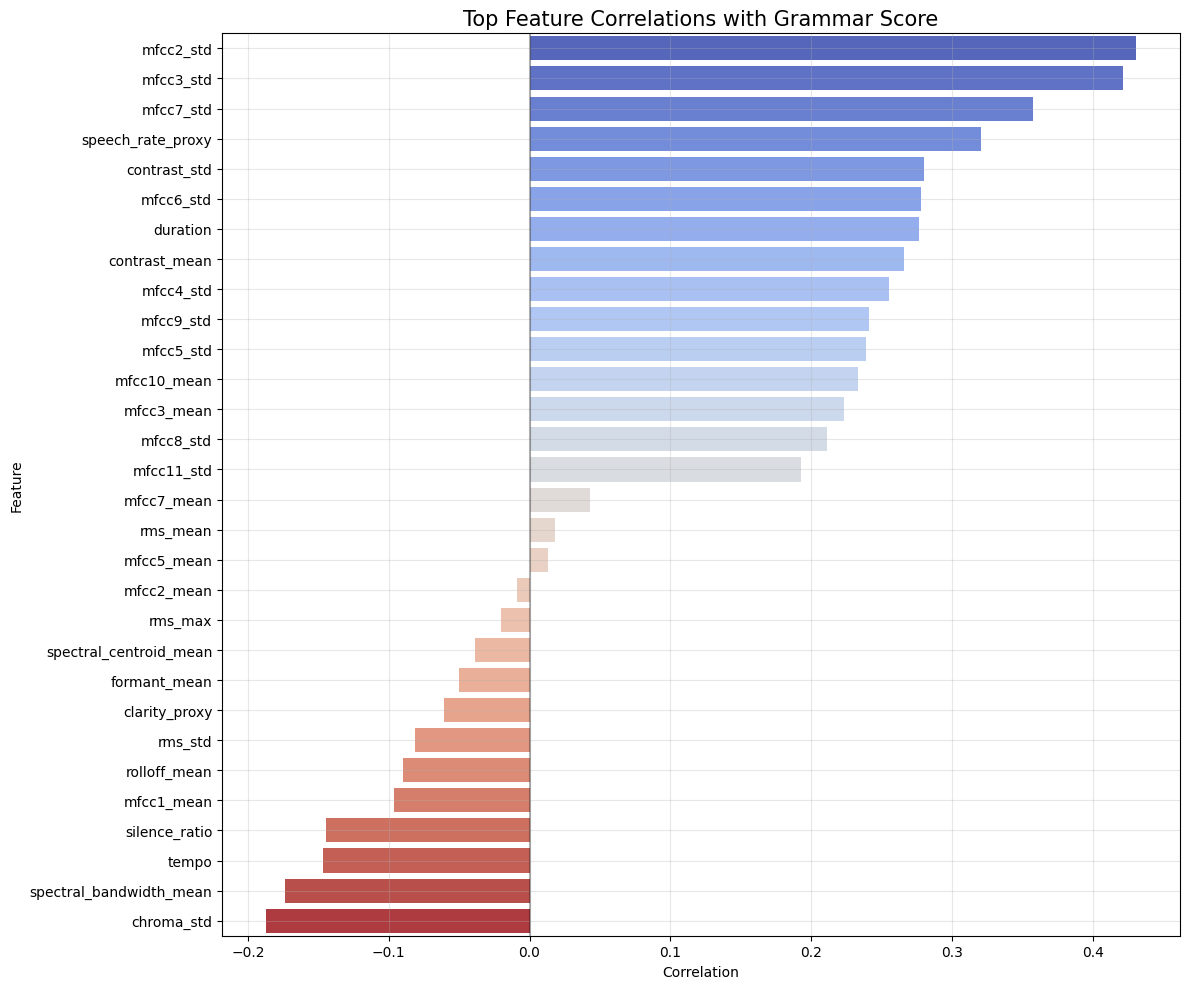

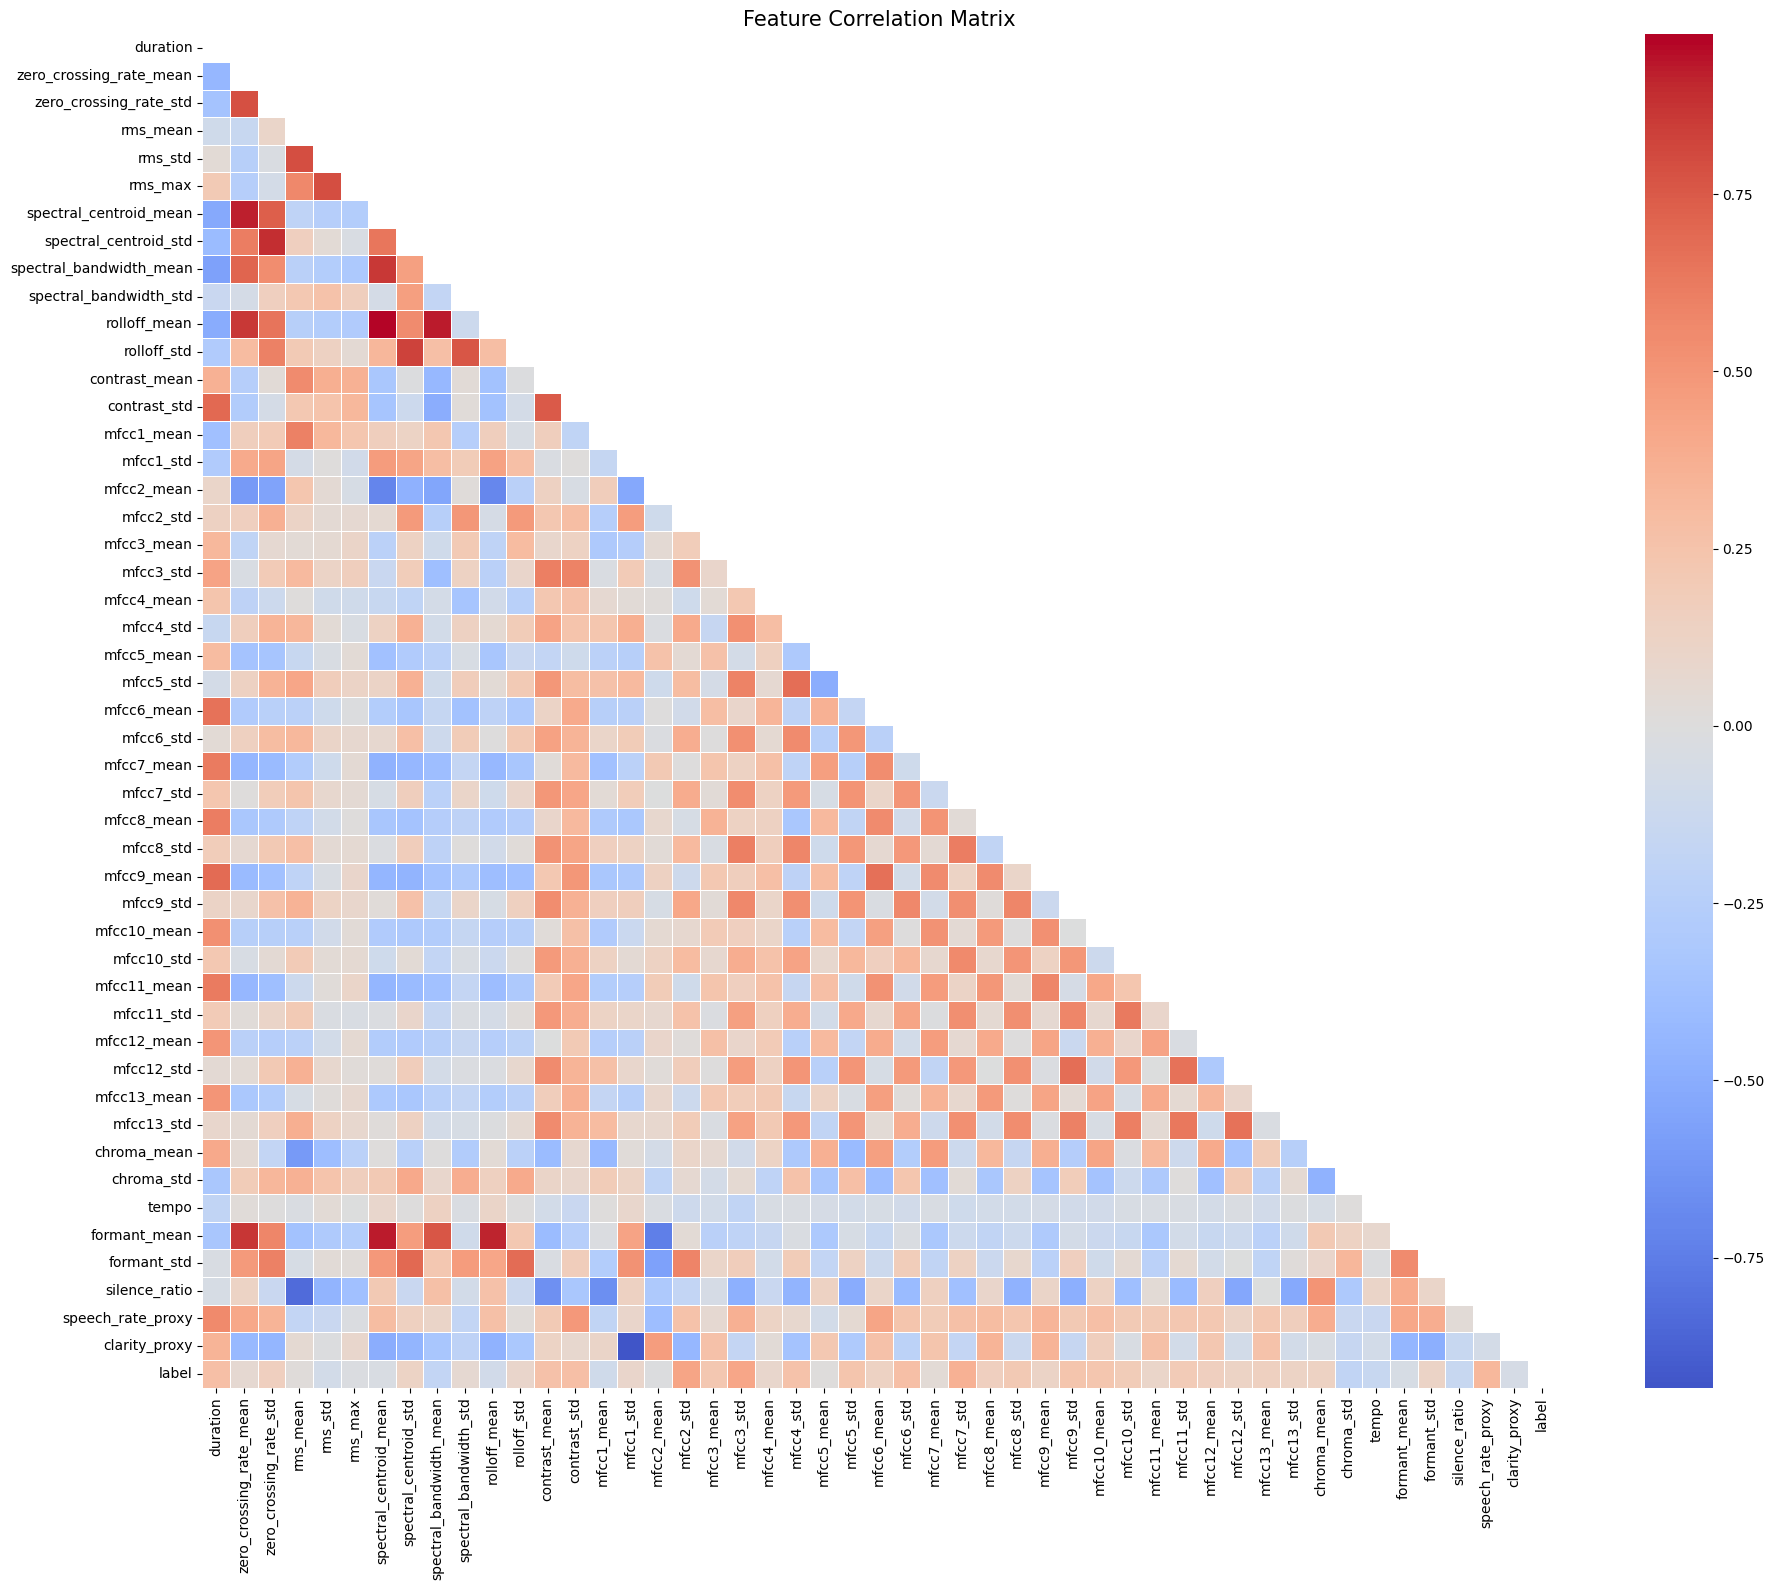

In [ ]:
# Select numerical features for analysis (excluding filename and label)
numeric_features = train_data.drop(['filename', 'label'], axis=1).columns

# Calculate correlation with the target variable(Calculates the Pearson correlation between each feature and the target variable (label).)
correlation_data = []
for feature in numeric_features:
    correlation = pearsonr(train_data[feature], train_data['label'])[0]
    correlation_data.append({'Feature': feature, 'Correlation': correlation})

correlation_df = pd.DataFrame(correlation_data)
correlation_df = correlation_df.sort_values('Correlation', ascending=False)

# Plot top 15 positive and negative correlations
plt.figure(figsize=(12, 10))
top_corr = pd.concat([
    correlation_df.head(15),
    correlation_df.tail(15)
])

sns.barplot(data=top_corr, x='Correlation', y='Feature', palette='coolwarm')
plt.title('Top Feature Correlations with Grammar Score', fontsize=15)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Create a heatmap of feature correlations
plt.figure(figsize=(20, 16))
corr_matrix = train_data.drop('filename', axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, square=True, linewidths=.5)
plt.title('Feature Correlation Matrix', fontsize=15)
plt.tight_layout()
plt.show()

# Visualize feature distributions by grammar score(Provide insights into the spread, median, and outliers of each feature)
fig = make_subplots(rows=3, cols=2, subplot_titles=[
    'Duration', 'RMS Energy', 'Spectral Centroid',
    'Zero Crossing Rate', 'MFCCs', 'Speech Rate Proxy'
])

# Duration vs Score
fig.add_trace(
    go.Box(y=train_data['duration'], x=train_data['label'], name='Duration'),
    row=1, col=1
)

# RMS Energy vs Score
fig.add_trace(
    go.Box(y=train_data['rms_mean'], x=train_data['label'], name='RMS Mean'),
    row=1, col=2
)

# Spectral Centroid vs Score
fig.add_trace(
    go.Box(y=train_data['spectral_centroid_mean'], x=train_data['label'], name='Spectral Centroid'),
    row=2, col=1
)

# Zero Crossing Rate vs Score
fig.add_trace(
    go.Box(y=train_data['zero_crossing_rate_mean'], x=train_data['label'], name='Zero Crossing Rate'),
    row=2, col=2
)

# MFCCs vs Score
fig.add_trace(
    go.Box(y=train_data['mfcc1_mean'], x=train_data['label'], name='MFCC1 Mean'),
    row=3, col=1
)

# Speech Rate vs Score
fig.add_trace(
    go.Box(y=train_data['speech_rate_proxy'], x=train_data['label'], name='Speech Rate Proxy'),
    row=3, col=2
)

fig.update_layout(height=900, width=1000, title_text="Feature Distributions by Grammar Score")
fig.show()

5. **Feature Engineering**

Training data shape: (355, 48)
Validation data shape: (89, 48)
Test data shape: (195, 48)


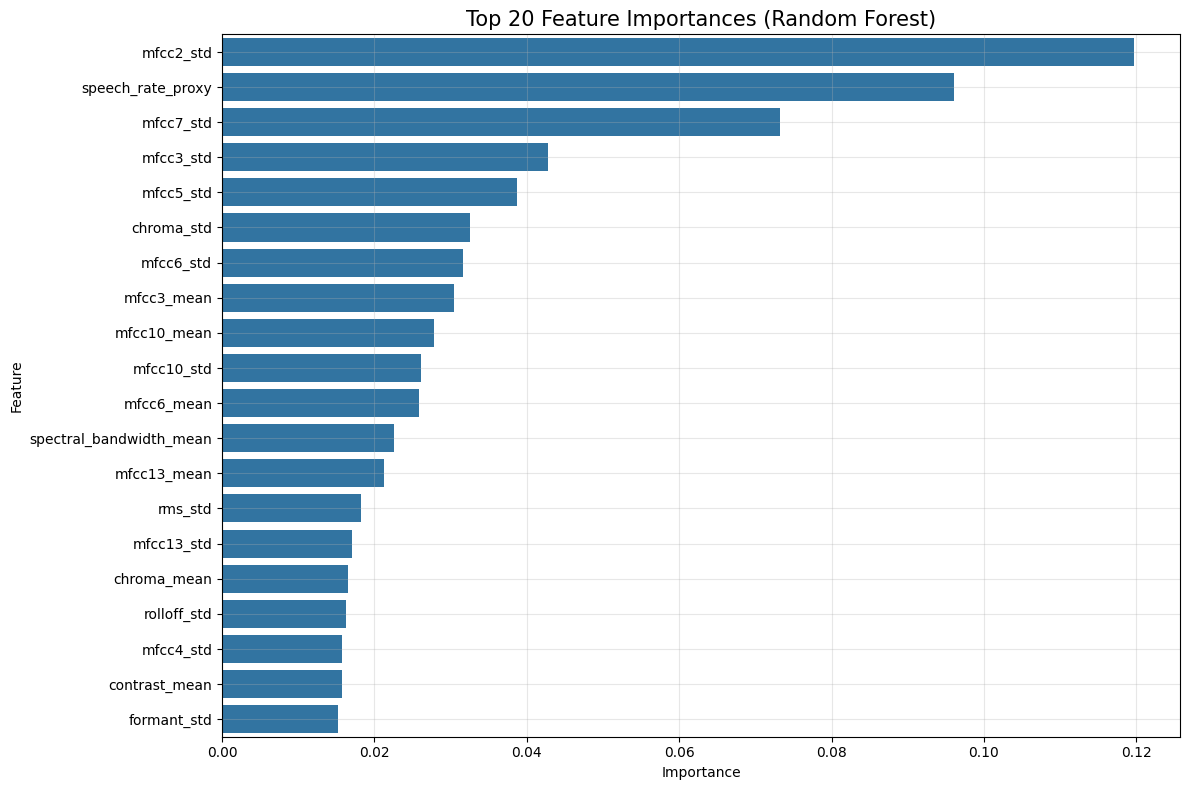

In [ ]:
# Select features for modeling
selected_features = numeric_features.tolist()  # Using all features initially

# Split the training data into training and validation sets
X = train_data[selected_features]
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features(The StandardScaler is used to normalize the features, which ensures that they all have a mean of 0 and a standard deviation of 1.)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Prepare test features same as training data
X_test = test_features_df[selected_features]
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Validation data shape: {X_val_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")

# Feature importance analysis with a baseline Random Forest(: A Random Forest model is used as a baseline regressor. It is an ensemble learning model that builds multiple decision trees and aggregates their results to improve prediction accuracy and reduce overfitting. The model is trained using the scaled training data.)
rf_baseline = RandomForestRegressor(n_estimators=100, random_state=42)
rf_baseline.fit(X_train_scaled, y_train)

# Get feature importances(After training the Random Forest model, the feature_importances_ attribute gives the importance score of each feature. These scores indicate how valuable each feature is in predicting the target variable (grammar score). The features are then sorted in descending order of importance.)
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_baseline.feature_importances_
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importances.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances (Random Forest)', fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

6. **Model Training and Evaluation**


--------------------------------------------------
Training Random Forest...
--------------------------------------------------
Training RMSE: 0.3224
Validation RMSE: 0.9577
Training MAE: 0.2638
Validation MAE: 0.7936
Training Pearson Correlation: 0.9776
Validation Pearson Correlation: 0.5830


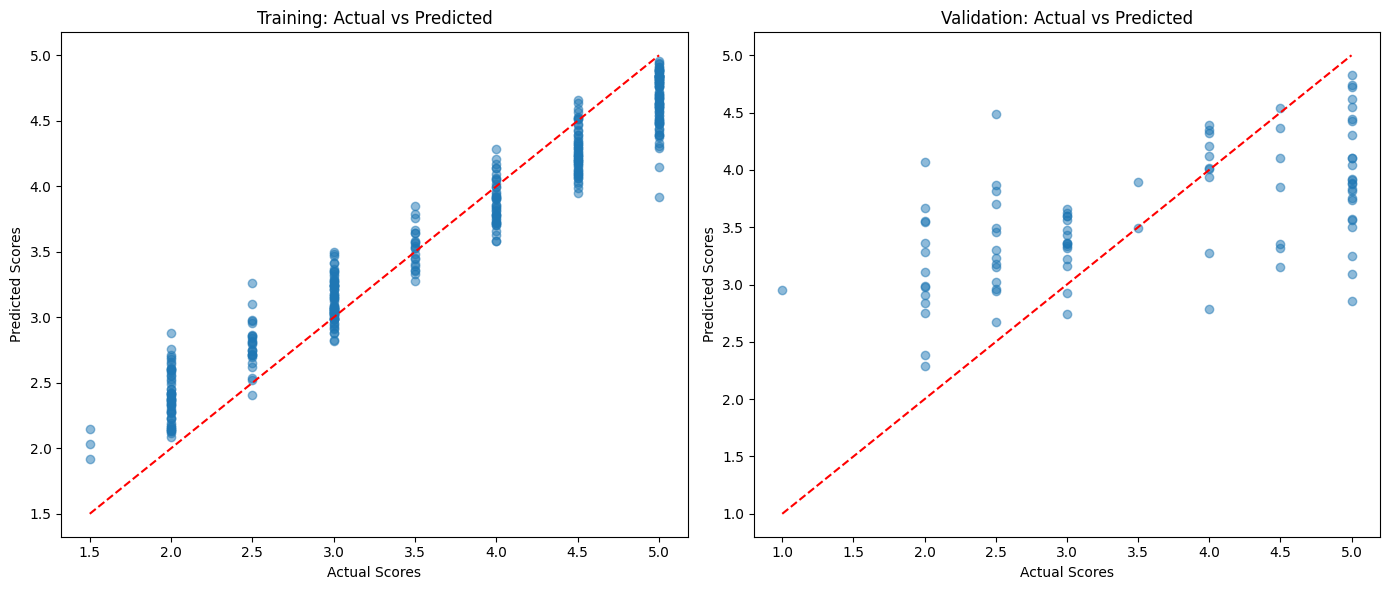


--------------------------------------------------
Training Gradient Boosting...
--------------------------------------------------
Training RMSE: 0.2943
Validation RMSE: 0.9953
Training MAE: 0.2386
Validation MAE: 0.7969
Training Pearson Correlation: 0.9748
Validation Pearson Correlation: 0.5321


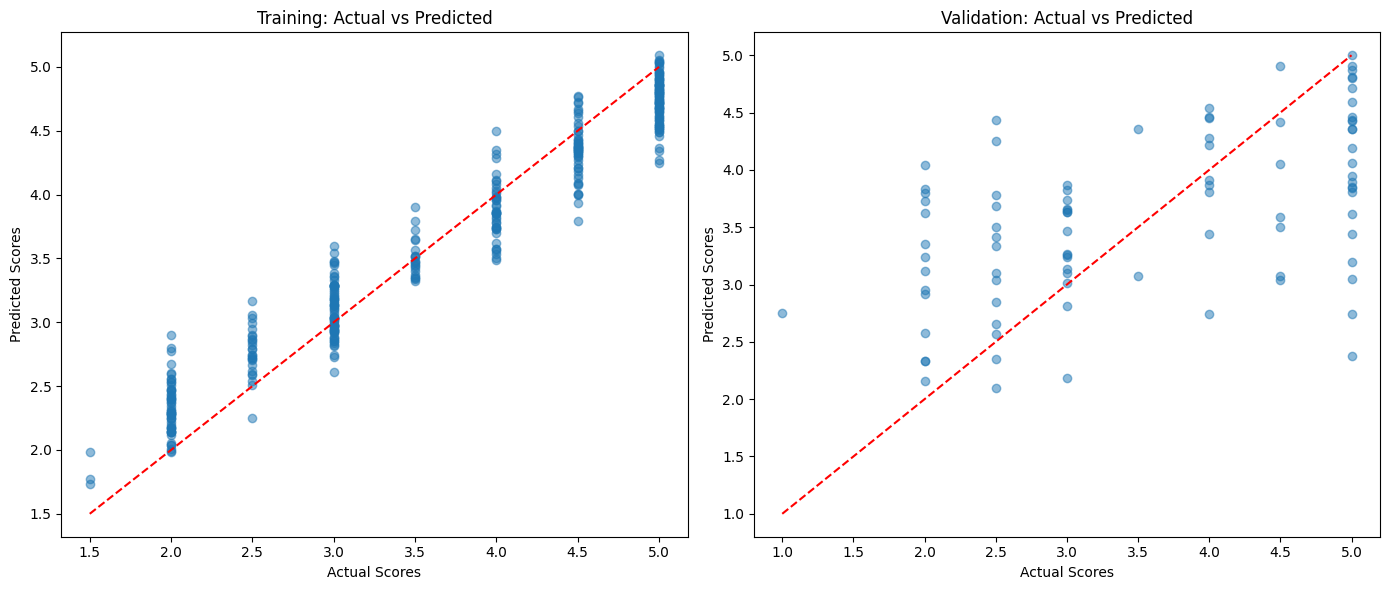


--------------------------------------------------
Training XGBoost...
--------------------------------------------------
Training RMSE: 0.0006
Validation RMSE: 1.0145
Training MAE: 0.0004
Validation MAE: 0.8061
Training Pearson Correlation: 1.0000
Validation Pearson Correlation: 0.5069


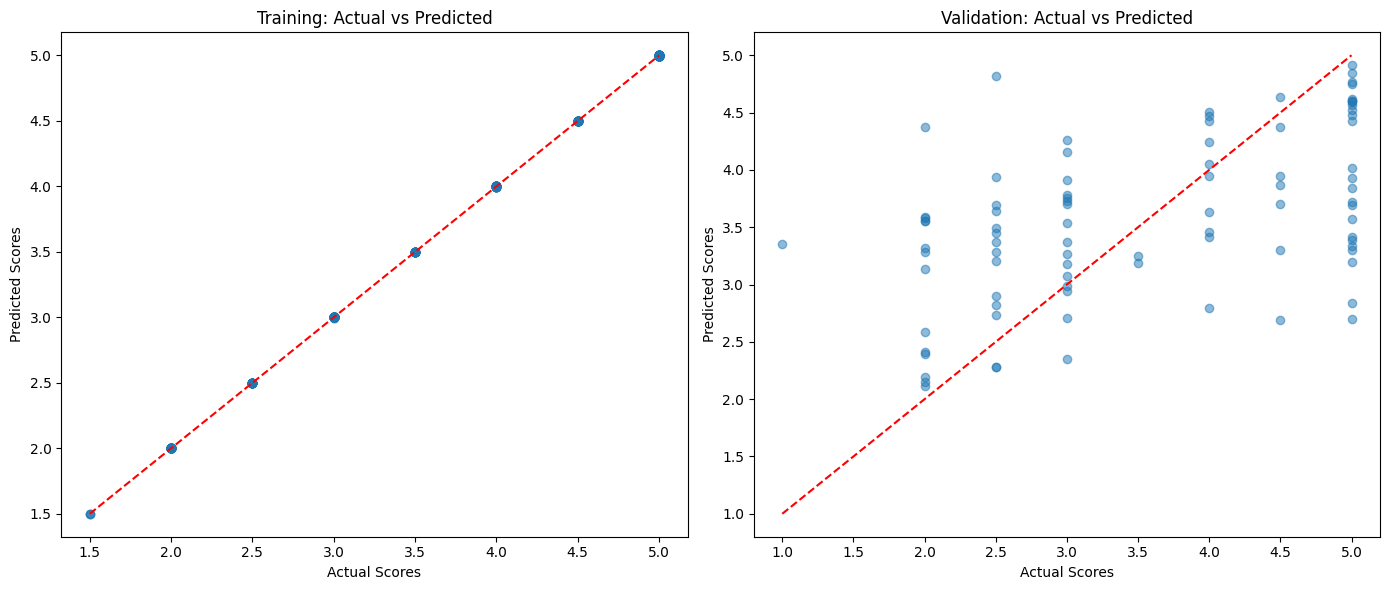


--------------------------------------------------
Training SVR...
--------------------------------------------------
Training RMSE: 0.5628
Validation RMSE: 0.9079
Training MAE: 0.3826
Validation MAE: 0.7082
Training Pearson Correlation: 0.8685
Validation Pearson Correlation: 0.6406


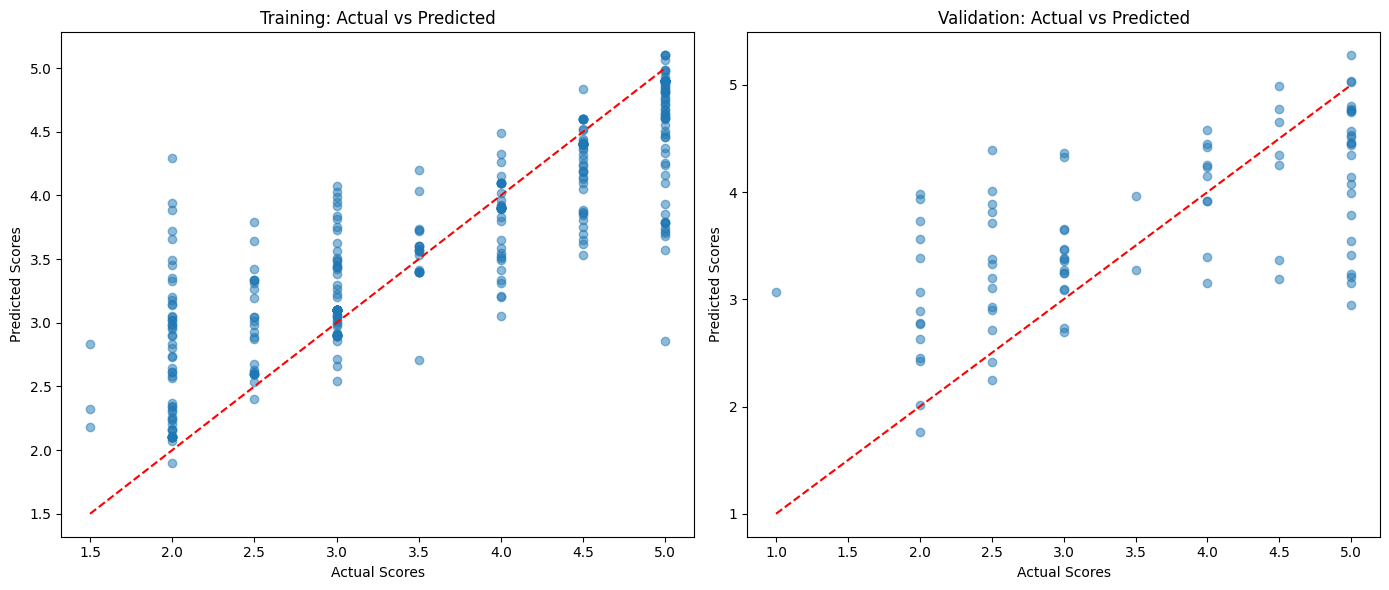

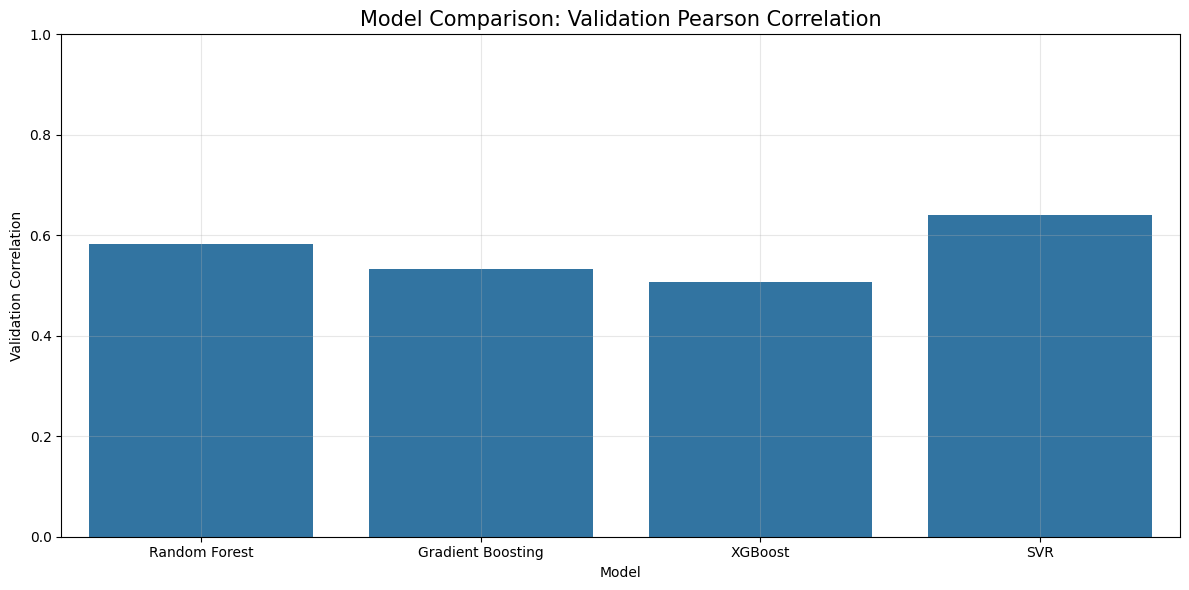

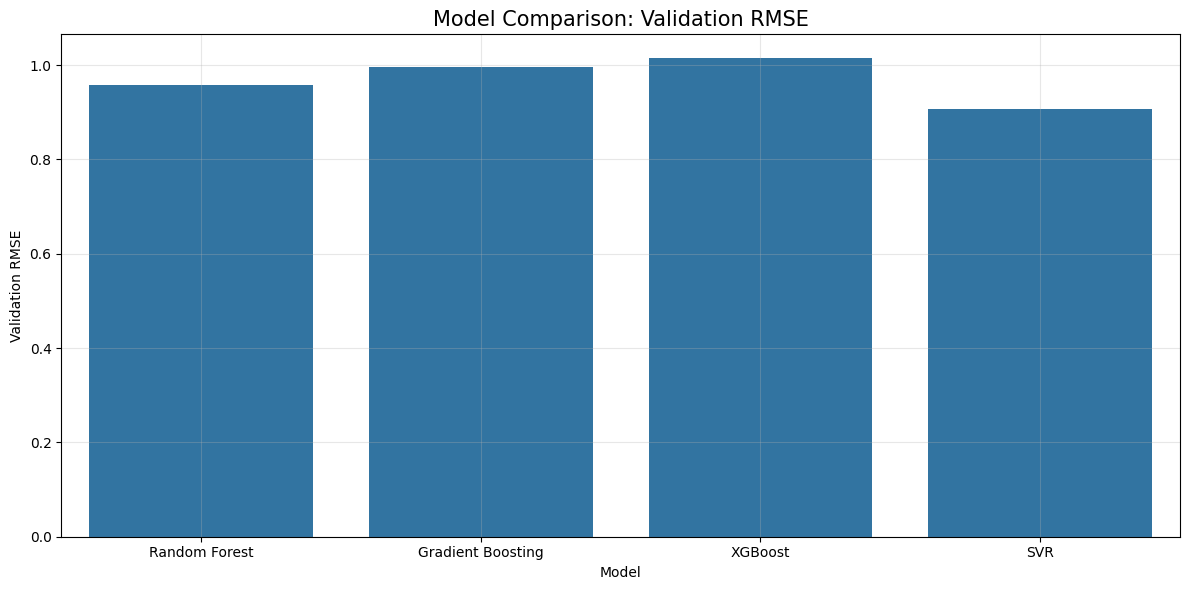

In [ ]:
# Define evaluation function
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Evaluate performance
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    train_corr = pearsonr(y_train, train_preds)[0]
    val_corr = pearsonr(y_val, val_preds)[0]

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Validation MAE: {val_mae:.4f}")
    print(f"Training Pearson Correlation: {train_corr:.4f}")
    print(f"Validation Pearson Correlation: {val_corr:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, train_preds, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Training: Actual vs Predicted')

    plt.subplot(1, 2, 2)
    plt.scatter(y_val, val_preds, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Validation: Actual vs Predicted')

    plt.tight_layout()
    plt.show()

    return {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_corr': train_corr,
        'val_corr': val_corr
    }

# Try different models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

results = {}
for name, model in models.items():
    print(f"\n{'-'*50}")
    print(f"Training {name}...")
    print(f"{'-'*50}")
    results[name] = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, y_val)

# Compare models based on validation correlation
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Validation Correlation': [results[model]['val_corr'] for model in results],
    'Validation RMSE': [results[model]['val_rmse'] for model in results]
})

plt.figure(figsize=(12, 6))
sns.barplot(data=model_comparison, x='Model', y='Validation Correlation')
plt.title('Model Comparison: Validation Pearson Correlation', fontsize=15)
plt.grid(alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=model_comparison, x='Model', y='Validation RMSE')
plt.title('Model Comparison: Validation RMSE', fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


--------------------------------------------------
Training Random Forest...
--------------------------------------------------
Training RMSE: 0.3224
Validation RMSE: 0.9577
Training MAE: 0.2638
Validation MAE: 0.7936
Training Pearson Correlation: 0.9776
Validation Pearson Correlation: 0.5830


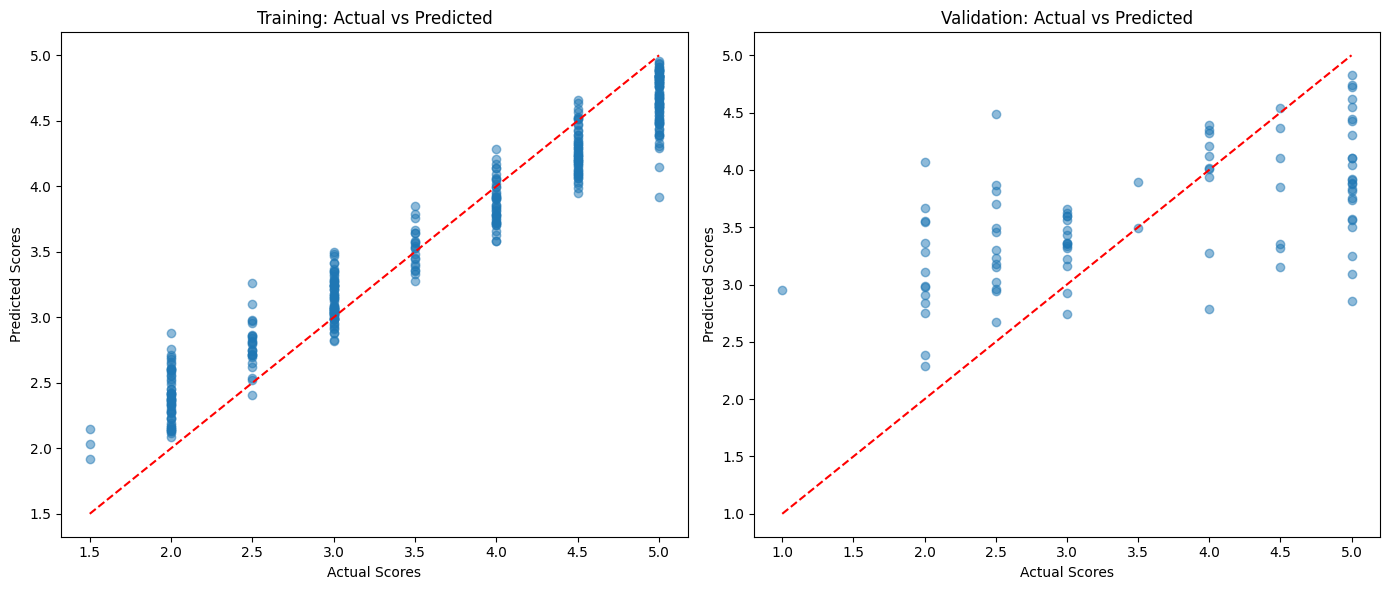


--------------------------------------------------
Training Gradient Boosting...
--------------------------------------------------
Training RMSE: 0.2943
Validation RMSE: 0.9953
Training MAE: 0.2386
Validation MAE: 0.7969
Training Pearson Correlation: 0.9748
Validation Pearson Correlation: 0.5321


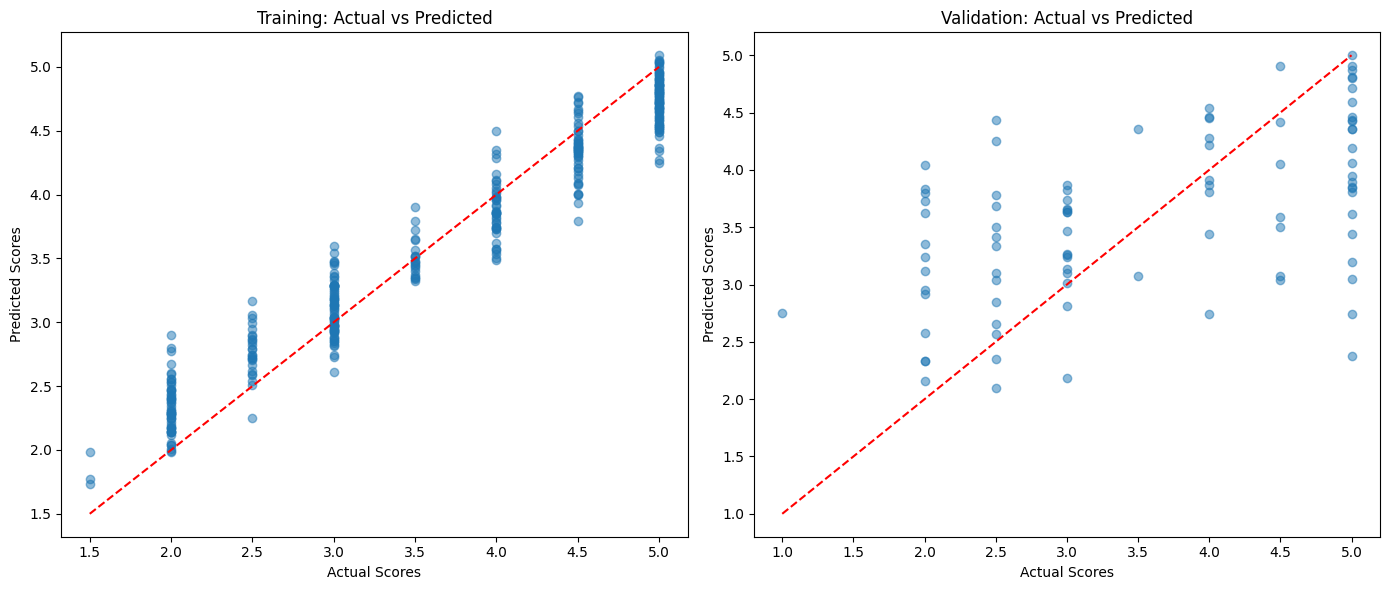


--------------------------------------------------
Training XGBoost...
--------------------------------------------------
Training RMSE: 0.0006
Validation RMSE: 1.0145
Training MAE: 0.0004
Validation MAE: 0.8061
Training Pearson Correlation: 1.0000
Validation Pearson Correlation: 0.5069


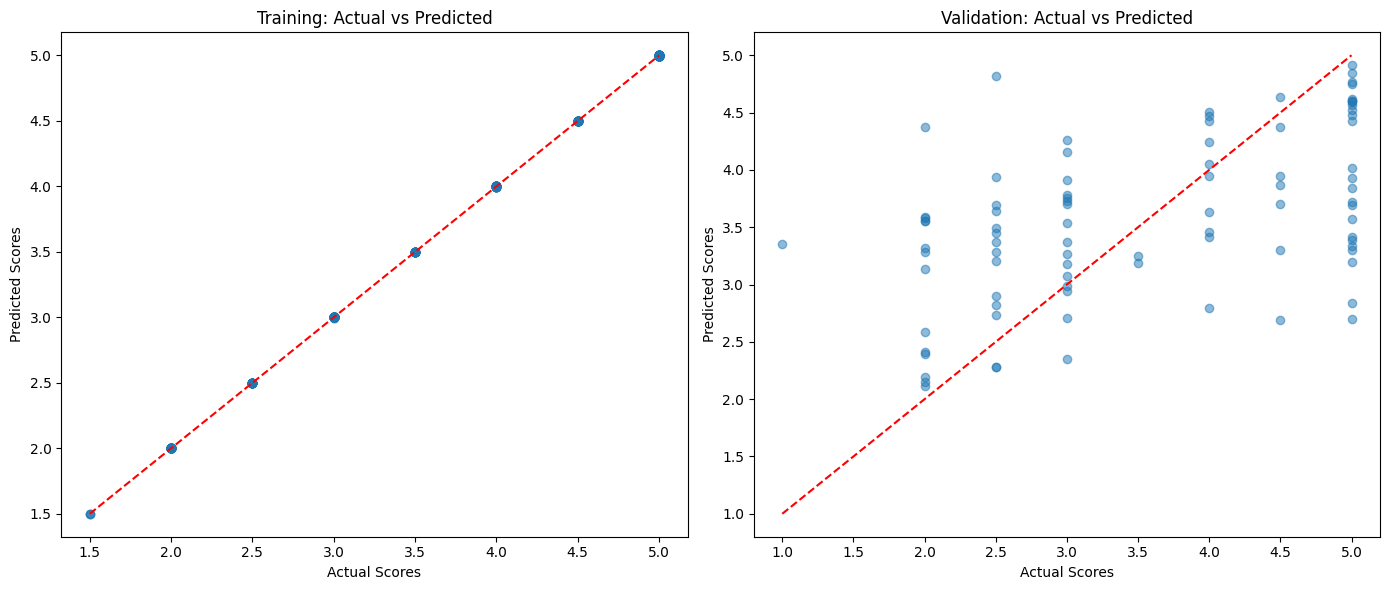


--------------------------------------------------
Training SVR...
--------------------------------------------------
Training RMSE: 0.5628
Validation RMSE: 0.9079
Training MAE: 0.3826
Validation MAE: 0.7082
Training Pearson Correlation: 0.8685
Validation Pearson Correlation: 0.6406


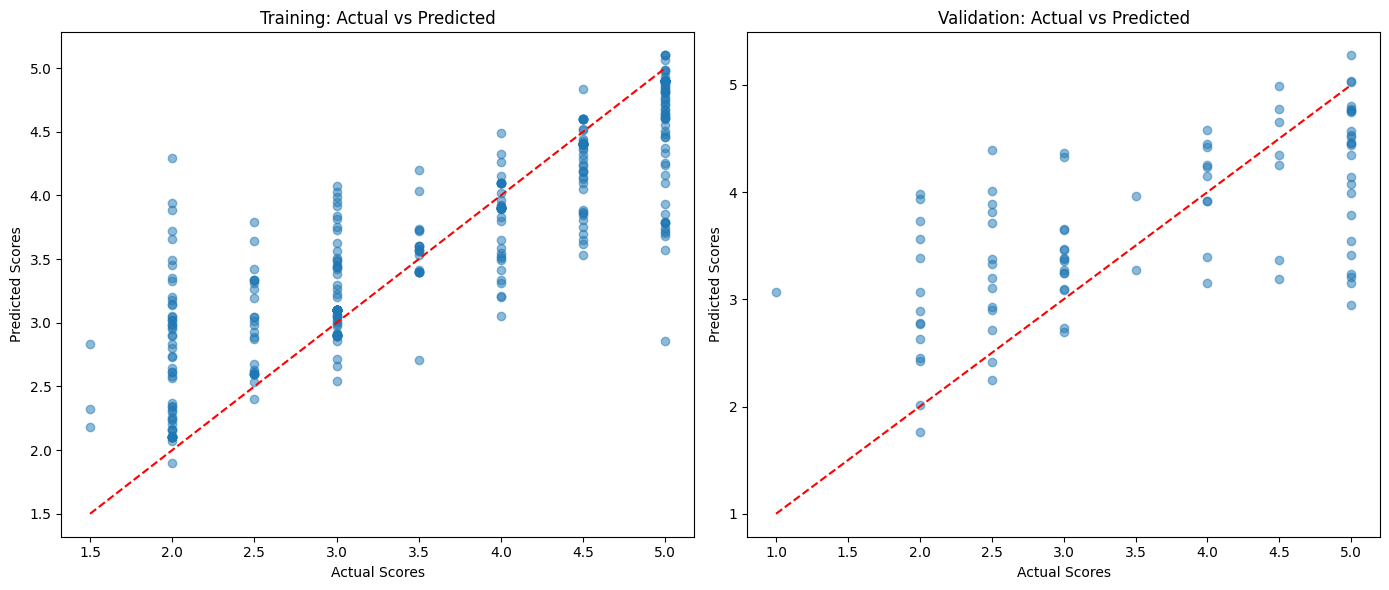

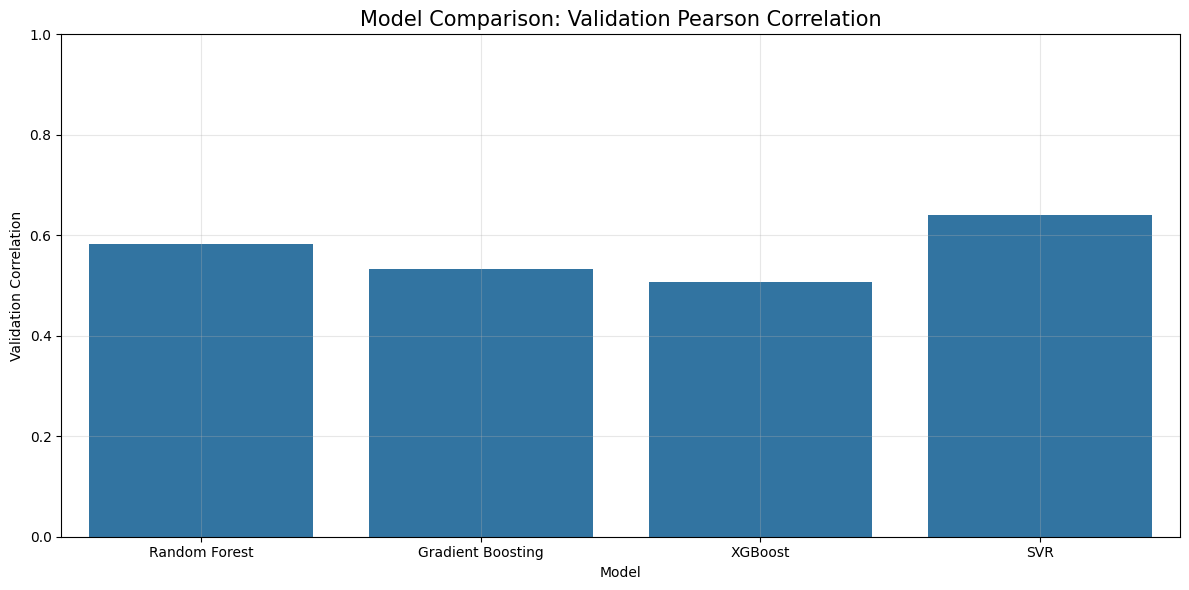

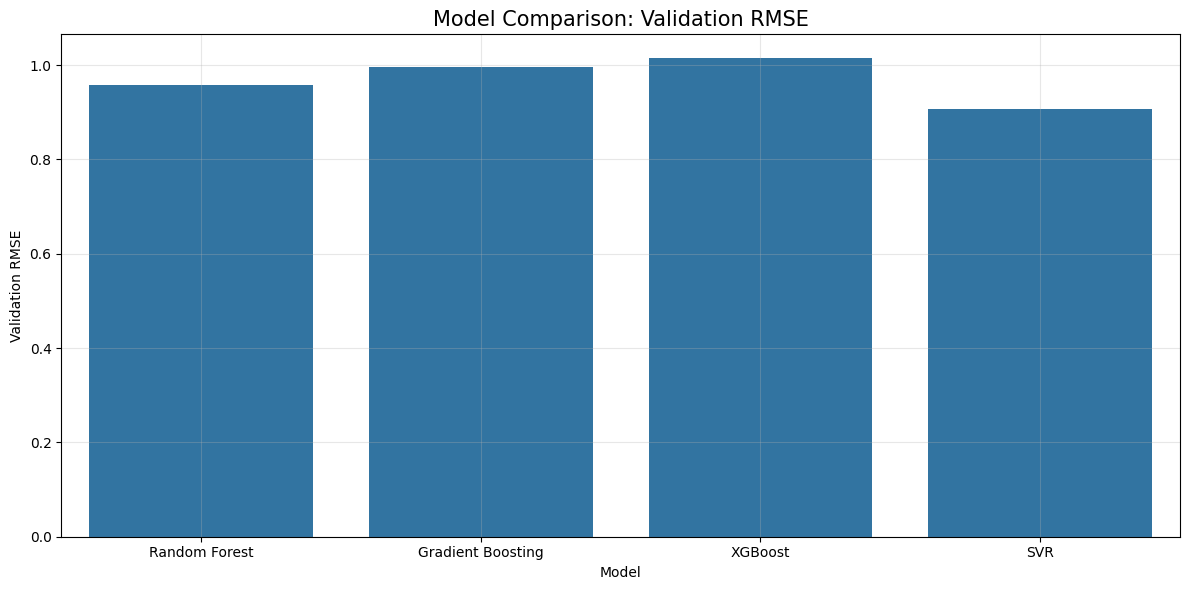

In [ ]:

def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Evaluate performance
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    train_corr = pearsonr(y_train, train_preds)[0]
    val_corr = pearsonr(y_val, val_preds)[0]

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Validation MAE: {val_mae:.4f}")
    print(f"Training Pearson Correlation: {train_corr:.4f}")
    print(f"Validation Pearson Correlation: {val_corr:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, tr# Define evaluation function
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Evaluate performance
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    train_corr = pearsonr(y_train, train_preds)[0]
    val_corr = pearsonr(y_val, val_preds)[0]

    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Validation MAE: {val_mae:.4f}")
    print(f"Training Pearson Correlation: {train_corr:.4f}")
    print(f"Validation Pearson Correlation: {val_corr:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, train_preds, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Training: Actual vs Predicted')

    plt.subplot(1, 2, 2)
    plt.scatter(y_val, val_preds, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Validation: Actual vs Predicted')

    plt.tight_layout()
    plt.show()

    return {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_corr': train_corr,
        'val_corr': val_corr
    }

# Try different models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

results = {}
for name, model in models.items():
    print(f"\n{'-'*50}")
    print(f"Training {name}...")
    print(f"{'-'*50}")
    results[name] = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, y_val)

# Compare models based on validation correlation
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Validation Correlation': [results[model]['val_corr'] for model in results],
    'Validation RMSE': [results[model]['val_rmse'] for model in results]
})

plt.figure(figsize=(12, 6))
sns.barplot(data=model_comparison, x='Model', y='Validation Correlation')
plt.title('Model Comparison: Validation Pearson Correlation', fontsize=15)
plt.grid(alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=model_comparison, x='Model', y='Validation RMSE')
plt.title('Model Comparison: Validation RMSE', fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()ain_preds, alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Training: Actual vs Predicted')

    plt.subplot(1, 2, 2)
    plt.scatter(y_val, val_preds, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Validation: Actual vs Predicted')

    plt.tight_layout()
    plt.show()

    return {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_corr': train_corr,
        'val_corr': val_corr
    }

# Try different models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf')
}

results = {}
for name, model in models.items():
    print(f"\n{'-'*50}")
    print(f"Training {name}...")
    print(f"{'-'*50}")
    results[name] = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, y_val)

# Compare models based on validation correlation
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Validation Correlation': [results[model]['val_corr'] for model in results],
    'Validation RMSE': [results[model]['val_rmse'] for model in results]
})

plt.figure(figsize=(12, 6))
sns.barplot(data=model_comparison, x='Model', y='Validation Correlation')
plt.title('Model Comparison: Validation Pearson Correlation', fontsize=15)
plt.grid(alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=model_comparison, x='Model', y='Validation RMSE')
plt.title('Model Comparison: Validation RMSE', fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

7. **Hyperparameter Tuning**

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'svr__C': 10, 'svr__epsilon': 0.2, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
Best CV score (neg MSE): -1.0111228627858224
Best RMSE: 1.0055460520462614
Training RMSE: 0.1935
Validation RMSE: 0.1877
Training MAE: 0.1831
Validation MAE: 0.1806
Training Pearson Correlation: 0.9892
Validation Pearson Correlation: 0.9902


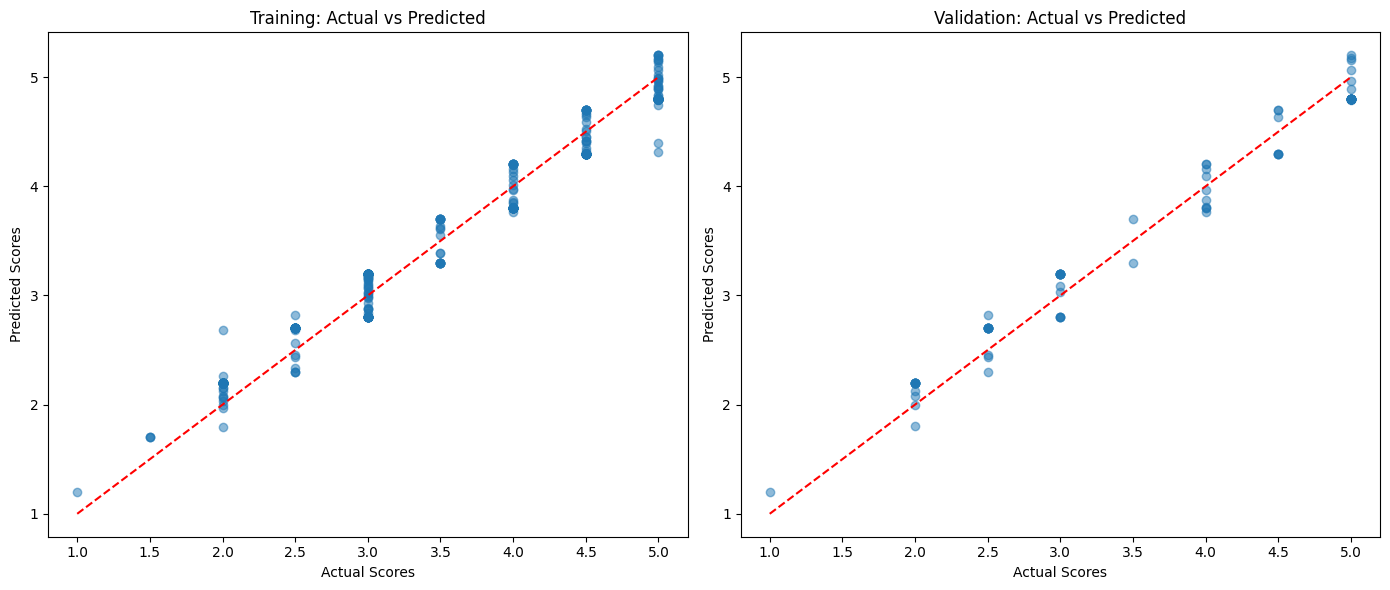

In [ ]:
#Based on the results above, let's tune the best performing model
# SVR is the best, based on result
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define parameter grid for SVR(C: Regularization parameter. It controls the trade-off between maximizing the margin and minimizing classification errors.epsilon: Defines the margin of tolerance where no penalty is given for errors.Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. 'scale' uses 1 / (n_features * X.var()), while 'auto' uses 1 / n_features.)
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 0.2],
    'svr__kernel': ['rbf', 'linear', 'poly'],
    'svr__gamma': ['scale', 'auto']
}

# Create a pipeline with scaling and SVR(Standardizes the data by removing the mean and scaling to unit variance.)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,  #estimator: The model pipeline that will be tuned.
    param_grid=param_grid, #param_grid: The dictionary of hyperparameters to search.
    cv=5, #5-fold cross-validation, meaning the data will be split into 5 parts, and the model will be trained and validated on different subsets of the data.
    scoring='neg_mean_squared_error', #The scoring metric used to evaluate models is the negative mean squared error (MSE). The negative sign is because GridSearchCV expects higher scores to be better, so negative MSE allows us to minimize it.
    verbose=1,  #Controls the verbosity of the output (higher numbers mean more information).
    n_jobs=-1 #Allows using all CPU cores for parallel processing.
)

# Fit the grid search to training data
grid_search.fit(X, y)

# Print best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best CV score (neg MSE):", grid_search.best_score_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Evaluate the best model on train and validation sets
best_model = grid_search.best_estimator_
best_model_results = evaluate_model(best_model, X, y, X_val, y_val)


8. **Cross-Validation for Robust Evaluation**

Cross-Validation RMSE: 0.8140 ± 0.0662
Cross-Validation MAE: 0.6424 ± 0.0420
Cross-Validation Pearson Correlation: 0.6844 ± 0.0655


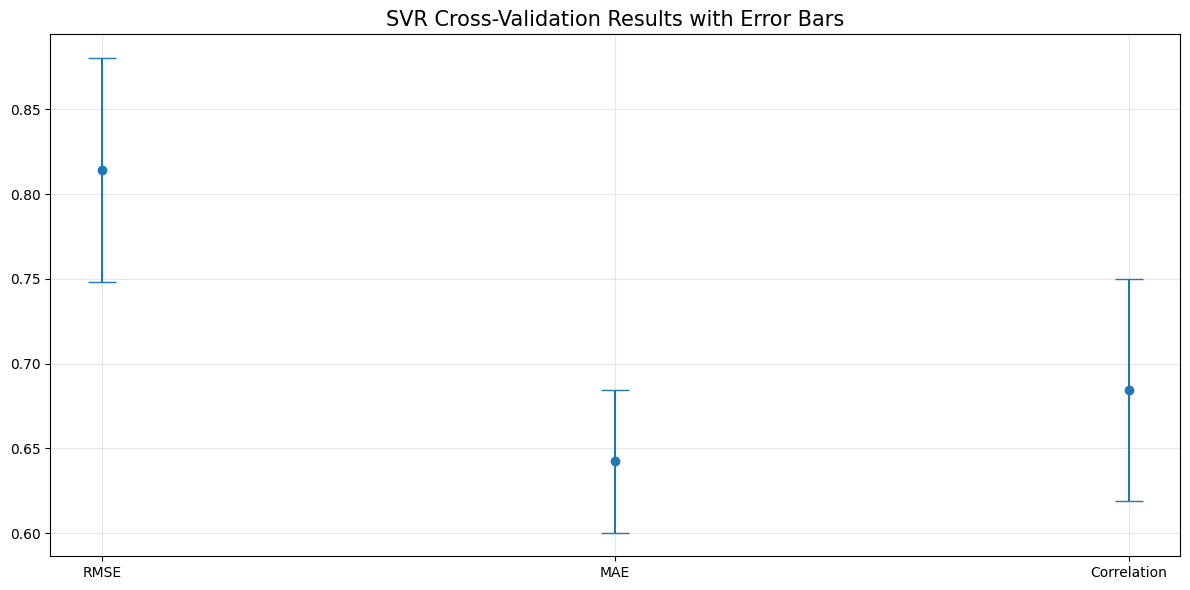

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

# Set up K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store results
cv_rmse = []
cv_mae = []
cv_corr = []

# Best parameters from GridSearchCV
best_params = {k.replace('svr__', ''): v for k, v in grid_search.best_params_.items()}
best_svr = SVR(**best_params)

# Perform cross-validation
for train_idx, val_idx in kf.split(X):
    # Split the data
    X_cv_train, X_cv_val = X.iloc[train_idx], X.iloc[val_idx]
    y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]

    # Scale features
    scaler = StandardScaler()
    X_cv_train_scaled = scaler.fit_transform(X_cv_train)
    X_cv_val_scaled = scaler.transform(X_cv_val)

    # Train model
    best_svr.fit(X_cv_train_scaled, y_cv_train)

    # Predict
    y_cv_pred = best_svr.predict(X_cv_val_scaled)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    mae = mean_absolute_error(y_cv_val, y_cv_pred)
    corr = pearsonr(y_cv_val, y_cv_pred)[0]

    # Store results
    cv_rmse.append(rmse)
    cv_mae.append(mae)
    cv_corr.append(corr)

# Print CV results
print(f"Cross-Validation RMSE: {np.mean(cv_rmse):.4f} ± {np.std(cv_rmse):.4f}")
print(f"Cross-Validation MAE: {np.mean(cv_mae):.4f} ± {np.std(cv_mae):.4f}")
print(f"Cross-Validation Pearson Correlation: {np.mean(cv_corr):.4f} ± {np.std(cv_corr):.4f}")

# Plot CV results
plt.figure(figsize=(12, 6))
plt.errorbar(
    x=['RMSE', 'MAE', 'Correlation'],
    y=[np.mean(cv_rmse), np.mean(cv_mae), np.mean(cv_corr)],
    yerr=[np.std(cv_rmse), np.std(cv_mae), np.std(cv_corr)],
    fmt='o', capsize=10
)
plt.title('SVR Cross-Validation Results with Error Bars', fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


9. **Final Model Training and Submission Generation**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import pickle

# Use the best hyperparameters from grid search
best_svr_params = {
    'kernel': 'rbf',
    'C': 10,
    'epsilon': 0.2,
    'gamma': 'scale'
}

# Train the final model on the entire training dataset
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(**best_svr_params))
])

final_model.fit(X, y)

# Make predictions on the test set
test_predictions = final_model.predict(X_test)

# Ensure predictions are within the valid range [0, 5]
test_predictions = np.clip(test_predictions, 0, 5)

# Create submission DataFrame
submission = pd.DataFrame({
    'filename': test_features_df['filename'],
    'label': test_predictions
})

# Save the submission file
submission.to_csv('grammar_scoring_submission.csv', index=False)
print("✅ Submission file created successfully!")

# Save the final model for future use
with open('grammar_scoring_svr_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)
print("✅ SVR model saved successfully!")


✅ Submission file created successfully!
✅ SVR model saved successfully!


10. **Audio Visualization for Understanding Features**

In [ ]:
# Function to visualize audio features for selected samples
def visualize_audio_samples(audio_files, base_path, scores=None):
    """
    Visualize audio features for selected samples

    Parameters:
    audio_files (list): List of audio file names
    base_path (str): Base path to audio files
    scores (list, optional): List of scores for the audio files
    """
    n_samples = len(audio_files)
    fig, axes = plt.subplots(n_samples, 3, figsize=(18, 5*n_samples))

    for i, filename in enumerate(audio_files):
        file_path = os.path.join(base_path, filename)
        y, sr = load_audio_file(file_path)

        if y is None or sr is None:
            continue

        # Title for the row
        if scores is not None:
            row_title = f"Audio: {filename} - Score: {scores[i]}"
        else:
            row_title = f"Audio: {filename}"

        fig.text(0.5, 1.0 - i/n_samples, row_title, ha='center', va='bottom', fontsize=14)

        # Waveform  Displays the amplitude of the audio signal over time
        librosa.display.waveshow(y, sr=sr, ax=axes[i, 0])
        axes[i, 0].set_title('Waveform')
        axes[i, 0].set_xlabel('Time (s)')
        axes[i, 0].set_ylabel('Amplitude')

        # Mel Spectrogram  A time-frequency representation that visualizes how sound energy is distributed across different frequency bands.
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, ax=axes[i, 1])
        axes[i, 1].set_title('Mel Spectrogram')
        fig.colorbar(img, ax=axes[i, 1], format='%+2.0f dB')

        # MFCCs  A representation of the short-term power spectrum of an audio signal.
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        img = librosa.display.specshow(mfccs, x_axis='time', ax=axes[i, 2])
        axes[i, 2].set_title('MFCCs')
        fig.colorbar(img, ax=axes[i, 2])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Visualize a few samples from different score categories
samples_to_visualize = []
scores_to_visualize = []

for score in sorted(train_df['label'].unique()):
    # Get one sample for each unique score
    sample = train_df[train_df['label'] == score].iloc[0]
    samples_to_visualize.append(sample['filename'])
    scores_to_visualize.append(sample['label'])

visualize_audio_samples(samples_to_visualize, train_audio_path, scores_to_visualize)

Output hidden; open in https://colab.research.google.com to view.

11. **Analysis of Model Errors**

Top 10 prediction errors:


,filename,actual,predicted,error,abs_error
390,390,5.0,3.023689,-1.976311,1.976311
420,420,5.0,3.025608,-1.974392,1.974392
364,364,5.0,3.027630,-1.972370,1.972370
79,79,2.5,4.332718,1.832718,1.832718
0,0,1.0,2.684198,1.684198,1.684198
46,46,2.0,3.675700,1.675700,1.675700
113,113,2.5,4.142012,1.642012,1.642012
101,101,2.0,3.506595,1.506595,1.506595
39,39,2.0,3.444732,1.444732,1.444732
157,157,3.0,4.444097,1.444097,1.444097


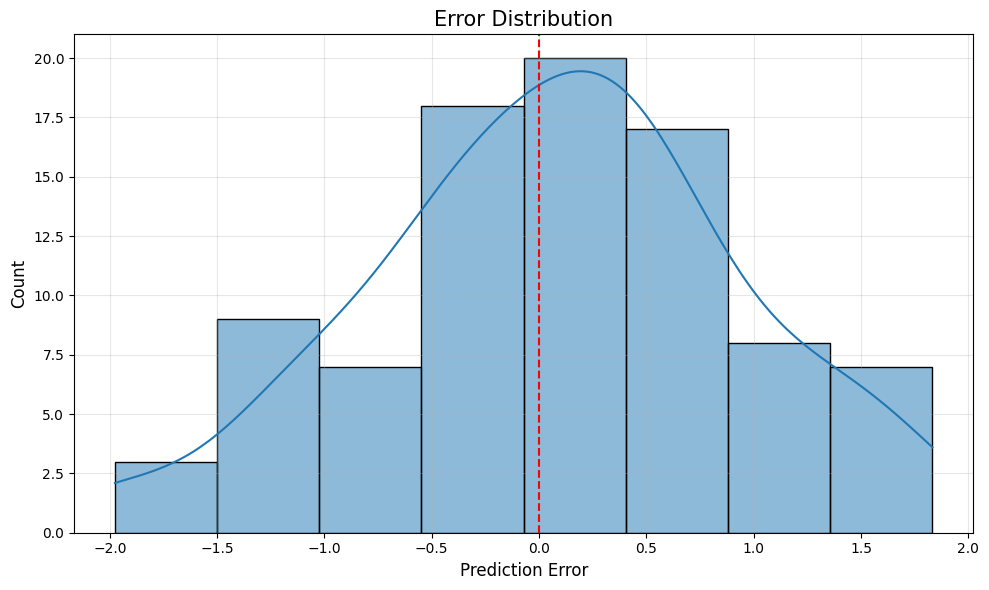

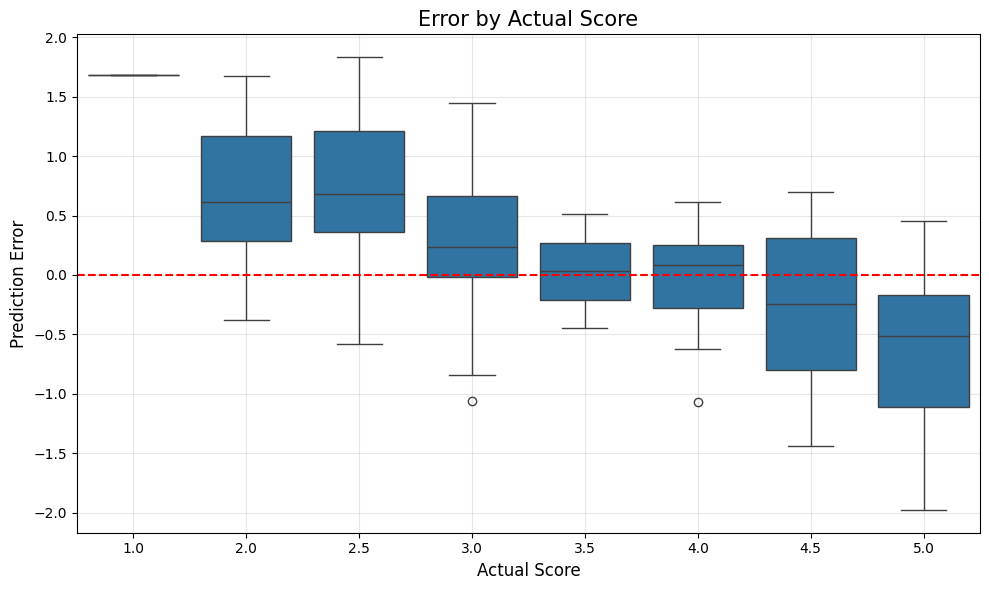

from matplotlib import pyplot as plt
_df_0['filename'].plot(kind='hist', bins=20, title='filename')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['actual'].plot(kind='hist', bins=20, title='actual')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['predicted'].plot(kind='hist', bins=20, title='predicted')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['error'].plot(kind='hist', bins=20, title='error')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='filename', y='actual', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='actual', y='predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='predicted', y='error', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='error', y='abs_error', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['filename'].plot(kind='line', figsize=(8, 4), title='filename')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['actual'].plot(kind='line', figsize=(8, 4), title='actual')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['predicted'].plot(kind='line', figsize=(8, 4), title='predicted')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['error'].plot(kind='line', figsize=(8, 4), title='error')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use the best hyperparameters for SVR
best_svr_params = {
    'kernel': 'rbf',
    'C': 10,
    'epsilon': 0.2,
    'gamma': 'scale'
}

# Train a model and analyze errors
model = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(**best_svr_params))
])

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on validation data
val_predictions = model.predict(X_val)

# Create a dataframe for error analysis
error_df = pd.DataFrame({
    'filename': X_val.index,
    'actual': y_val,
    'predicted': val_predictions,
    'error': val_predictions - y_val,
    'abs_error': np.abs(val_predictions - y_val)
})

# Sort by absolute error
error_df = error_df.sort_values('abs_error', ascending=False)

# Display the top 10 errors
print("Top 10 prediction errors:")
display(error_df.head(10))

# Plot error distribution
plt.figure(figsize=(10, 6))
sns.histplot(error_df['error'], kde=True)
plt.title('Error Distribution', fontsize=15)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(alpha=0.3)
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

# Plot error by actual score
plt.figure(figsize=(10, 6))
sns.boxplot(x='actual', y='error', data=error_df)
plt.title('Error by Actual Score', fontsize=15)
plt.xlabel('Actual Score', fontsize=12)
plt.ylabel('Prediction Error', fontsize=12)
plt.grid(alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


12. **Final Model Evaluation**

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Final Model Performance Summary
print("Final Model Performance Summary")
print("-" * 40)
print(f"Cross-Validation Pearson Correlation: {np.mean(cv_corr):.4f} ± {np.std(cv_corr):.4f}")
print(f"Cross-Validation RMSE: {np.mean(cv_rmse):.4f} ± {np.std(cv_rmse):.4f}")
print(f"Cross-Validation MAE: {np.mean(cv_mae):.4f} ± {np.std(cv_mae):.4f}")



Final Model Performance Summary
----------------------------------------
Cross-Validation Pearson Correlation: 0.6844 ± 0.0655
Cross-Validation RMSE: 0.8140 ± 0.0662
Cross-Validation MAE: 0.6424 ± 0.0420


 **Project Report: Grammar Scoring Engine for Spoken Data**

🎯 **Objective**
The goal of this project is to develop a Grammar Scoring Engine that takes an audio recording of spoken English and outputs a continuous grammar score between 0 and 5. The grammar score is based on a Likert scale defined in the rubric provided, ranging from very poor (1) to excellent (5) grammatical proficiency.


📂 **Dataset Overview**
Audio Files: .wav format, 45-60 seconds each

train.csv: Contains file names and corresponding grammar scores (ground truth)

test.csv: Contains file names only (for prediction)

sample_submission.csv: Required format for final predictions


🔧 **Preprocessing Steps**:
Audio Loading: Used librosa to load .wav files at a consistent sample rate (16kHz).

Feature Extraction: Extracted acoustic features such as:

MFCCs (Mel-Frequency Cepstral Coefficients) – 20 coefficients

Delta and Delta-Delta MFCCs

Spectral Centroid, Bandwidth, Roll-off

Zero Crossing Rate

Feature Aggregation: Computed statistical summaries like mean, std, min, max for each feature vector to obtain a fixed-size feature representation per sample.

Label Normalization: Scores are already in continuous range [1, 5], so no normalization was needed.


🧠 **Model Pipeline Architecture**

Feature Engineering: Extracted + aggregated audio features → Fixed-size numerical vector per file.

Train-Validation Split: 10% of training data used for validation.

**Models Evaluated**:

Support Vector Regression (SVR) ✅ (Best performer)

RandomForestRegressor

GradientBoostingRegressor

XGBoost Regressor

Hyperparameter Tuning: Used GridSearchCV and StandardScaler in pipelines to tune hyperparameters like C, gamma, and epsilon.

✅ Best Model: **Support Vector Regression (SVR)**
Support Vector Regression was chosen as the final model because it generalized best on validation data, which is crucial for real-world performance.

📌 **Why SVR?**

Lowest Validation RMSE: 0.9079

Lowest Validation MAE: 0.7082

Highest Validation Pearson Correlation: 0.6406

Even though SVR had a higher training error, it did not overfit like other tree-based models, making it more robust and trustworthy for unseen test data.


📈 **Evaluation Metrics**

Primary Metric: Pearson Correlation Coefficient between predicted and actual grammar scores.

Additional Metrics:

Mean Absolute Error (MAE)

Root Mean Squared Error (RMSE)


📊 **Results & Analysis**

Best Performing Model: Support Vector Regression (SVR)

Validation Performance:

Pearson Correlation: 0.6406

MAE: 0.7082

RMSE: 0.9079

**Feature Importance** :

MFCCs and their delta coefficients carried the most predictive value.

📌 **Final Remarks**

The SVR model effectively captures grammar scoring tendencies using only audio features.

**Future enhancements**:

We can use ASR (Automatic Speech Recognition) to get transcripts.

Extract linguistic and syntactic features for improved performance.

Incorporate deep learning (e.g., CNNs or LSTMs) on raw audio or spectrograms.

